#  Programming assignment 8: Recurrent neural networks

This time you'll find yourself delving into the heart (and other intestines) of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train RNN instead;

It's dangerous to go alone, take these:

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Our data
The dataset contains ~8k earthling names from different cultures, all in latin transcript.

This notebook has been designed so as to allow you to quickly swap names for something similar: deep learning article titles, IKEA furniture, pokemon names, etc.

In [2]:
import os
start_token = " "

with open("names") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token+name for name in names]

In [3]:
print ('n samples = ',len(names))
for x in names[::1000]:
    print (x)

n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


max length = 16


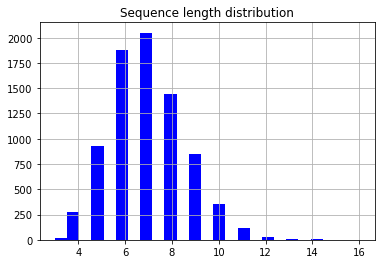

In [57]:
MAX_LENGTH = max(map(len,names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len,names)),bins=25, color='blue');
plt.grid(True);

# Text processing

First we need next to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [10]:
#all unique characters go here
tokens = set(''.join(names))

tokens = list(tokens)

n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)

assert 50 < n_tokens < 60

n_tokens =  55


### Cast everything from symbols into identifiers

Tensorflow string manipulation is a bit tricky, so we'll work around it. 
We'll feed our recurrent neural network with ids of characters from our dictionary.

To create such dictionary, let's assign 

In [11]:
token_to_id = {x: y for y, x in enumerate(tokens)}

In [12]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [13]:
def to_matrix(names,max_len=None,pad=0,dtype='int32'):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len,names))
    names_ix = np.zeros([len(names),max_len],dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get,names[i]))
        names_ix[i,:len(name_ix)] = name_ix

    return names_ix.T

In [14]:
#Example: cast 4 random names to matrices, pad with zeros
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]).T)

 Abagael
 Glory
 Prissie
 Giovanne
[[49 11 28 14 39 14 20  9  0]
 [49 40  9 35 23  5  0  0  0]
 [49 44 23 10 34 34 10 20  0]
 [49 40 10 35 12 14 38 38 20]]


# Recurrent neural network

We can rewrite recurrent neural network as a consecutive application of dense layer to input $x_t$ and previous rnn state $h_t$. This is exactly what we're gonna do now.
<img src="./rnn.png" width=480>

Since we're training a language model, there should also be:
* An embedding layer that converts character id x_t to a vector.
* An output layer that predicts probabilities of next phoneme

In [36]:
import keras
from keras.layers import Concatenate, Dense, Embedding

rnn_num_units = 64
embedding_size = 16

#Let's create layers for our recurrent network
#Note: we create layers but we don't "apply" them yet
embed_x = Embedding(n_tokens,embedding_size) # an embedding layer that converts character ids into embeddings

# Dense layer that maps input and previous state to new hidden state, [x_t,h_t] -> h_t+1
get_h_next = Dense(rnn_num_units, activation='relu')

# Dense layer that maps current hidden state to probabilities of characters [h_t+1] -> P(x_t+1|h_t+1)
get_probas = Dense(n_tokens, activation='softmax')

# Note: please either set the correct activation to Dense or write it manually in rnn_one_step

In [37]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces next state and output
    given prev input and previous state.
    We'll call this method repeatedly to produce the whole sequence.
    
    Follow inline isntructions to complete the function.
    """
    # Convert character id into embedding
    x_t_emb = embed_x(tf.reshape(x_t,[-1,1]))[:,0]
    
    # Concatenate x embedding and previous h state
    x_and_h = tf.concat([x_t_emb, h_t], 1)
    
    # Compute next state given x_and_h
    h_next = get_h_next(x_and_h)
    
    # Get probabilities for language model P(x_next|h_next)
    output_probas = get_probas(h_next)
    
    return output_probas, h_next

### RNN loop

Once rnn_one_step is ready, let's apply it in a loop over name characters to get predictions.

Let's assume that all names are at most length-16 for now, so we can simply iterate over them in a for loop.


In [38]:
input_sequence = tf.placeholder('int32',(MAX_LENGTH,None))
batch_size = tf.shape(input_sequence)[1]

predicted_probas = []
h_prev = tf.zeros([batch_size,rnn_num_units]) # initial hidden state

for t in range(MAX_LENGTH):
    x_t = input_sequence[t]
    probas_next,h_next = rnn_one_step(x_t,h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)
    
predicted_probas = tf.stack(predicted_probas)

## RNN: loss and gradients

Let's gather a matrix of predictions for $P(x_{next}|h)$ and the corresponding correct answers.

Our network can then be trained by minimizing crossentropy between predicted probabilities and those answers.

In [39]:
predictions_matrix = tf.reshape(predicted_probas[:-1],[-1,len(tokens)])
answers_matrix = tf.one_hot(tf.reshape(input_sequence[1:],[-1]), n_tokens)

In [46]:
loss = tf.reduce_mean(tf.reduce_sum(-answers_matrix*tf.log(tf.clip_by_value(predictions_matrix, 1e-4, 1.0)),
                                    reduction_indices=[1], keep_dims=None, axis=None))
optimize = tf.train.AdamOptimizer().minimize(loss)

### The training loop

In [49]:
from IPython.display import clear_output
from random import sample
s = keras.backend.get_session()
s.run(tf.global_variables_initializer())
history = []

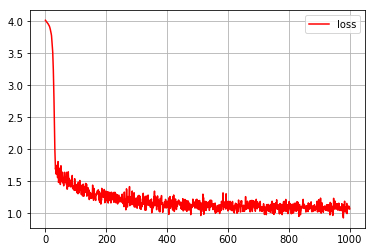

In [50]:
for i in range(1000):
    batch = to_matrix(sample(names,32),max_len=MAX_LENGTH)
    loss_i,_ = s.run([loss,optimize],{input_sequence:batch})
    
    
    history.append(loss_i)
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss', color='red')
        plt.legend()
        plt.grid(True)
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: sampling
Once we've trained our network a bit, let's get to actually generating stuff. All we need is the `rnn_one_step` function you have written above.

In [51]:
x_t = tf.placeholder('int32',(None,))
h_t = tf.Variable(np.zeros([1,rnn_num_units],'float32'))

next_probs,next_h = rnn_one_step(x_t,h_t)

In [52]:
def generate_sample(seed_phrase=' ',max_length=MAX_LENGTH):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        The phrase is set using the variable seed_phrase
        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    s.run(tf.assign(h_t,h_t.initial_value))
    
    # Feed the seed phrase, if any
    for ix in x_sequence[:-1]:
         s.run(tf.assign(h_t,next_h),{x_t:[ix]})
    
    # Start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs,_ = s.run([next_probs,tf.assign(h_t,next_h)],{x_t:[x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens,p=x_probs[0]))
        
    return ''.join([tokens[ix] for ix in x_sequence])

In [53]:
for _ in range(10):
    print(generate_sample())

 VoyntiriFFFFFFF
 BelieFFFFFFFFFF
 LeidyFFFFFFFFFF
 FenneFFFFFFFFFF
 KaateFFFFFFFFFF
 SlugtcaFFFFFFFF
 EwoeneeFFFFFFFF
 CatedexFFFFFFFF
 DedinesFFFFFFFF
 FynstenieFFFFFF


In [54]:
for _ in range(50):
    print(generate_sample(' Trump'))

 TrumpteeriaFFFF
 TrumpyFFFFFFFFF
 TrumperFFFFFFFF
 TrumpiyFFFFFFFF
 TrumperolibeFFF
 TrumpvenFFFFFFF
 TrumpelFFFFFFFF
 TrumpFFFFFFFFFF
 TrumpenFFFFFFFF
 TrumpouneFFFFFF
 TrumpinFFFFFFFF
 TrumpeenFFFFFFF
 TrumpudFFFFFFFF
 TrumpinbanFFFFF
 TrumparraFFFFFF
 TrumpFFFFFFFFFF
 TrumpudFFFFFFFF
 TrumpecaFFFFFFF
 TrumpeFFFFFFFFF
 TrumpFFFFFFFFFF
 TrumpaFFFFFFFFF
 TrumpyFFFFFFFFF
 TrumpitFFFFFFFF
 TrumpFFFFFFFFFF
 TrumpafeFFFFFFF
 TrumpFFFFFFFFFF
 TrumpheFFFFFFFF
 TrumpeyFFFFFFFF
 TrumpaaderdeFFF
 TrumpanlinaFFFF
 TrumphanFFFFFFF
 TrumpareFFFFFFF
 TrumpenyFFFFFFF
 TrumpeyFFFFFFFF
 TrumplyFFFFFFFF
 TrumpelFFFFFFFF
 TrumpBieFFFFFFF
 TrumpaFFFFFFFFF
 TrumpoteFFFFFFF
 TrumpieFFFFFFFF
 TrumpteFFFFFFFF
 TrumpFFFFFFFFFF
 TrumpianFFFFFFF
 TrumpelmFFFFFFF
 Trumpa-baloFFFF
 TrumpanFFFFFFFF
 TrumpasaFFFFFFF
 TrumpinFFFFFFFF
 TrumpuleFFFFFFF
 TrumpanFFFFFFFF


### Submit to coursera

In [59]:
samples = [generate_sample(' Al') for i in range(25)]
submission = (history, samples)

In [66]:
from importlib import reload
import submit
reload(submit);

In [67]:
submit.submit_char_rnn(submission, email='sjd1882@gmail.com', token='mHck7Wva20jsZCFn')

Submitted to Coursera platform. See results on assignment page!
